In [273]:
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import statsmodels
import csv
import pickle

# Processing Data from PostGRES Output

Creating a single JSON file for each participant from PostGRES data that contains a single list of all participant data

In [274]:
fileprefix = "full_3" # pilot_[1,2,4]
filepath = '../results/{}_results.json'.format(fileprefix)


In [275]:
with open(filepath, 'r') as f:
    all_data = json.load(f)

In [276]:
part_data = {}

count = 0
for participant in all_data['values']:
    count+=1
    print(count, participant[2])
    try:
        part_object = json.loads(participant[17])
        part_object["Beginhit"] = participant[11]
        part_object["Beginexp"] = participant[12]
        part_object["Endhit"] = participant[13]
        part_object["psiturkStatus"] = participant[15]
        part_object["browser"] = participant[5]
        part_object["platform"] = participant[6]
        part_object["language"] = participant[7]
        
        if part_object["workerId"].startswith("debug"):
            continue

        part_data[part_object["workerId"]] = part_object
        with open('../results/{}_{}.json'.format(fileprefix, part_object['workerId']), 'w') as fw:
            json.dump(part_object, fw)
    except:
        print("Fail")
        continue;

1 614e41e008fb1f027c0af049
2 60ed6ef739959cc28d143526
3 60bbc368a316ee5421a1153b
4 6128b55755dd29503d0d3e7a
5 612cb8236aa1cef2599e6f59
6 60ddfc8d812b5c63f22c1ac3
7 61227cb134d2ee7a4a125ef7
8 60f9b64aa48e0aa3697f3557
9 5eb12f8510e0ce205e7b25c7
10 5db050bee16e28001752bc92
11 60f56f0103876eae7c0d870f
12 64835cdc41f91285bcbd2de1
13 6483247637d20bcecd41963b
14 64087b8444f656e9e2b74446
15 612530f3e28f8c909170bf0a
16 60f814d5348f2f80c0e60c3a
17 6083b4263964f54ff206124e
18 614e446e77a6b2d836cb3817
19 61731b36eb6014947f8d2be7
20 64724264f02fe05e61736abe
21 611ce44efa3822c780ae383e
22 61267b828ead584bcf092e35
23 60c142fad3c33f80288c9aa2
24 63ee65e3470c23cb401ca89a
25 610a706bf1254be97abf1a34
26 5fdcad62eed16d2504b27f5a
27 649e9418513d333d2da7e637
28 6455c9898efbcab4a705968b
29 60c9c994c019ca2e1836e7d7
30 5e593e1b5f129b0168be047a
31 6152c05b866a2622004014a5
32 604a4755d62e5590404b5426
33 60f49bc8ed8976b9448e3730
34 6171b75b3c2b59f8487b4814
35 606c6e9f7e86c0264ab3d7d8
36 debugTPzGx
37 60fc7f3f9cc8

In [277]:
part_data.keys()


dict_keys(['614e41e008fb1f027c0af049', '60ed6ef739959cc28d143526', '60bbc368a316ee5421a1153b', '6128b55755dd29503d0d3e7a', '612cb8236aa1cef2599e6f59', '60ddfc8d812b5c63f22c1ac3', '61227cb134d2ee7a4a125ef7', '60f9b64aa48e0aa3697f3557', '5eb12f8510e0ce205e7b25c7', '5db050bee16e28001752bc92', '60f56f0103876eae7c0d870f', '64835cdc41f91285bcbd2de1', '6483247637d20bcecd41963b', '64087b8444f656e9e2b74446', '612530f3e28f8c909170bf0a', '60f814d5348f2f80c0e60c3a', '6083b4263964f54ff206124e', '614e446e77a6b2d836cb3817', '61731b36eb6014947f8d2be7', '64724264f02fe05e61736abe', '611ce44efa3822c780ae383e', '61267b828ead584bcf092e35', '60c142fad3c33f80288c9aa2', '63ee65e3470c23cb401ca89a', '610a706bf1254be97abf1a34', '5fdcad62eed16d2504b27f5a', '649e9418513d333d2da7e637', '6455c9898efbcab4a705968b', '60c9c994c019ca2e1836e7d7', '5e593e1b5f129b0168be047a', '6152c05b866a2622004014a5', '604a4755d62e5590404b5426', '60f49bc8ed8976b9448e3730', '6171b75b3c2b59f8487b4814', '606c6e9f7e86c0264ab3d7d8', '60fc7f3f

In [278]:
len(part_data.keys())

118

# Reading Data from Already Created Participant Data Files

In [6]:
fileprefix = "pilot_3" # pilot_#, final
datafolder = '../results/'

all_part_files = [filename for filename in os.listdir(datafolder) if filename.startswith(fileprefix) and 'results' not in filename]
all_part_paths = [datafolder + filename for filename in all_part_files]

In [7]:
part_data = {}
for file in all_part_paths:
    with open(file, 'r') as f:
        participant = json.load(f)
        part_data[participant["workerId"]] = participant



In [223]:
len(part_data.keys())

62

# Analyzing Trial Data

Create a list of objects, one for each participant's data

In [323]:
part_stats_dicts = []
extract_max_trials = 40
for participant in part_data.values():
    try:
        beginhit = datetime.datetime.strptime(participant['Beginhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginhit = None
    try:
        endhit = datetime.datetime.strptime(participant['Endhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        endhit = None
    try:    
        beginexp = datetime.datetime.strptime(participant['Beginexp'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginexp = None
    
    try:
        hitLength = (endhit-beginhit).seconds
    except TypeError:
        hitLength = None
    
    try:
        expLength = (endhit-beginexp).seconds
    except TypeError:
        expLength = None
        
    numPracTrials = 0
    trialLengths = []
    trialScores = []
    rewardsWithheld = []
    reached_max_trials = False
    effort = "-1"
    age = None
    gender = None
    colorblind = None
    print(participant['workerId'])
    try:
        firstTrialStamp = participant['data'][0]['dateTime']
        lastTrialStamp = participant['data'][-1]['dateTime']
    except:
        print("No data")
        continue
    if hitLength is None:
        hitLength = (lastTrialStamp - firstTrialStamp) / 1000
    if expLength is None:
        expLength = (lastTrialStamp - firstTrialStamp) / 1000
        
    mdp_timestamps = {
        "start" : 0,
        "end" : 0,
        "done": False
    }
    current_state = "stroop_1"
    last_trial = participant['data'][0]
    finishHITReached = False
    demographicsAvailable = False
    feedback = ""
    alreadyParticipated = ""
    comments = ""
    whatStrategy = ""
    clicksL1 = []
    firstLevelAns = {}
    clickStratsValid = True
    strategyImprove = ""
    difficult = ""
    num_correct_sequences = 0
    final_quiz_responses = None
    for idx, trial in enumerate(participant['data']):
        trial_type = trial['trialdata']['trial_type']
        try:
            trial_id = str(trial['trialdata']['trial_id'])
        except KeyError:
            trial_id = ""
        
        if participant['workerId'] == "5eb40f1f0d916d20d9db9144":
            print("{}\t{}\t{}".format(trial_type, trial_id, idx))
            
        if trial_id.startswith("mouselab_instructions_1") and not mdp_timestamps["done"]:
            mdp_timestamps["done"] = True
            mdp_timestamps["start"] = trial['dateTime']
        
        if "num_correct_sequences" in trial['trialdata']:
            num_correct_sequences = trial['trialdata']['num_correct_sequences']
        
        if trial_id.startswith("final_quiz"):
            mdp_timestamps["end"] = trial['dateTime']
            final_quiz_responses = trial['trialdata']['response']

        if trial_id.startswith("self_report_2"):
            firstLevelAns = trial['trialdata']['response']
        
        if trial_id.startswith("finish_fail"):
            feedback = trial['trialdata']['response']['Q0']
            age = trial['trialdata']['response']['Q1']
            gender = trial['trialdata']['response']['Q2']
            colorblind = trial['trialdata']['response']['Q3']
            comments = trial['trialdata']['response']['Q4']
            demographicsAvailable = True
            
        if trial_type == 'mouselab-mdp':
            if trial_id.startswith('practice'):
                numPracTrials += 1
            else:
                if extract_max_trials and len(trialScores) == extract_max_trials:
                    if not reached_max_trials:
                        reached_max_trials = True
                        print(f"!!! More than {extract_max_trials} trials found !!!")
                trialLengths.append(trial['trialdata']['trialTime'])
                
                trialScores.append(trial['trialdata']['score'])
                rewardsWithheld.append(trial['trialdata']['withholdReward'])
                clicks = trial['trialdata']['queries']['click']['state']['target']
                cL1 = len([c for c in clicks if int(c) in [1,12,23]])
                clicksL1.append(cL1)
        if trial_type == 'survey-html-form':
            
            if 'effort' in trial['trialdata']['response']:
                effort = trial['trialdata']['response']['effort']
                age = trial['trialdata']['response']['age']
                gender = trial['trialdata']['response']['gender']
                colorblind = trial['trialdata']['response']['colorblind']
                demographicsAvailable = True
        
        elif trial_type == 'survey-text':
            if trial_id.startswith("self_report"):
                whatStrategy = trial['trialdata']['response']['Q0']
                strategyImprove = trial['trialdata']['response']['Q1']
                difficult = trial['trialdata']['response']['Q2']
            
            elif not trial_id.startswith("answer"):
                #print(trial['trialdata'])
                feedback = trial['trialdata']['response']['Q0']
                alreadyParticipated = trial['trialdata']['response']['Q1']
                comments = trial['trialdata']['response']['Q2']
        
        if trial_type == 'html-button-response':
            if "Finish HIT" in trial['trialdata']['stimulus']:
                finishHITReached = True
        last_trial = trial
    
    # Checking if click strategies are invalid
    if firstLevelAns:
        # Criteria 1: clicks made on first level nodes on more than 10% of the trials
        madeL1Clicks = sum([bool(c) for c in clicksL1])/len(clicksL1) >= 0.10
        # Criteria 2: did not pay attention to the values at the first level - average agreement with
        #   negative statements greater than 2 (indifference)
        
        # Assessed by answers to Q5 and Q6
        possible_answers = ["Strongly disagree", "Disagree", "Neither disagree nor agree", "Agree", "Strongly agree"]
        
        # "... I did pay attention"
        scoreQ5 = possible_answers.index(firstLevelAns["Q5"])
        # "... I did NOT pay attention"
        scoreQ6 = possible_answers.index(firstLevelAns["Q6"])
        adj_scoreQ6 = len(possible_answers) - scoreQ6 - 1
        
        avg_attn_score = (scoreQ5 + adj_scoreQ6) / 2
        clickStratsValid = not madeL1Clicks or (avg_attn_score >= 2)
    dropoutPoint = None
    for obj, type_ in zip([mdp_timestamps], ["mdp"]):
        if obj["start"] > 0 and obj["end"] == 0:
            
            dropoutPoint = type_
            obj["end"] = lastTrialStamp
            
    if not dropoutPoint:
        if len(trialLengths) == 0:
            dropoutPoint = "beginning"
        elif not finishHITReached:
            dropoutPoint = "finishHIT"
            
    if dropoutPoint:
        print(participant['workerId'], dropoutPoint)
    part_stats_dict = {
        "workerId": participant['workerId'],
        "Beginhit": beginhit,
        "Endhit": endhit,
        "Beginexp": beginexp,
        "psiturkStatus" : participant["psiturkStatus"],
        "browser" : participant["browser"],
        "platform" : participant["platform"],
        "language" : participant["language"],
        "hitLength": hitLength,
        "expLength": expLength,
        "totalLengthSum": (lastTrialStamp - firstTrialStamp) / 1000,
        "numQuizAttempts": numPracTrials / 2,
        "trialLengths": trialLengths,
        "trialScores" : trialScores,
        "numTrialsCompleted": len(trialLengths),
        "rewardsWithheld": rewardsWithheld,
        "effort": effort,
        "clicksL1": clicksL1,
        "age":age,
        "colorblind":colorblind,
        "gender":gender,
        "condition": participant['condition'],
        "mouselabLength" : (mdp_timestamps["end"] - mdp_timestamps["start"]) / 1000,
        "dropoutPoint" : dropoutPoint,
        "feedback": feedback,
        "alreadyParticipated": alreadyParticipated,
        "comments": comments,
        "finishHITReached": finishHITReached,
        "demographicsAvailable": demographicsAvailable,
        "whatStrategy": whatStrategy,
        "strategyImprove": strategyImprove,
        "difficult": difficult,
        "firstLevelAns": firstLevelAns,
        "num_correct_sequences": num_correct_sequences,
        "final_quiz_responses": final_quiz_responses,
        "clickStratsValid": clickStratsValid
    }
    if 'questiondata' in participant and 'final_score' in participant['questiondata']:
        part_stats_dict['finalScore'] = participant['questiondata']['final_score']
    else:
        part_stats_dict['finalScore'] = sum([score for (score, withheld) in zip(trialScores, rewardsWithheld) if not withheld])
    
    part_stats_dict["expLengthSum"] = part_stats_dict["mouselabLength"]
    part_stats_dict["expLengthDiff"] = part_stats_dict["expLengthSum"] - part_stats_dict["expLength"]
    if len(trialLengths) > 0:
        part_stats_dict["averageTrialLength"] = sum(trialLengths) / len(trialLengths)
        part_stats_dict["propWithheld"] = sum(rewardsWithheld) / len(rewardsWithheld)
        
    part_stats_dicts.append(part_stats_dict)
    

614e41e008fb1f027c0af049
No data
60ed6ef739959cc28d143526
60bbc368a316ee5421a1153b
6128b55755dd29503d0d3e7a
6128b55755dd29503d0d3e7a mdp
612cb8236aa1cef2599e6f59
612cb8236aa1cef2599e6f59 mdp
60ddfc8d812b5c63f22c1ac3
60ddfc8d812b5c63f22c1ac3 mdp
61227cb134d2ee7a4a125ef7
60f9b64aa48e0aa3697f3557
5eb12f8510e0ce205e7b25c7
5db050bee16e28001752bc92
60f56f0103876eae7c0d870f
64835cdc41f91285bcbd2de1
!!! More than 40 trials found !!!
6483247637d20bcecd41963b
6483247637d20bcecd41963b mdp
64087b8444f656e9e2b74446
612530f3e28f8c909170bf0a
612530f3e28f8c909170bf0a mdp
60f814d5348f2f80c0e60c3a
6083b4263964f54ff206124e
614e446e77a6b2d836cb3817
61731b36eb6014947f8d2be7
64724264f02fe05e61736abe
611ce44efa3822c780ae383e
61267b828ead584bcf092e35
60c142fad3c33f80288c9aa2
63ee65e3470c23cb401ca89a
610a706bf1254be97abf1a34
5fdcad62eed16d2504b27f5a
649e9418513d333d2da7e637
649e9418513d333d2da7e637 mdp
6455c9898efbcab4a705968b
6455c9898efbcab4a705968b mdp
60c9c994c019ca2e1836e7d7
5e593e1b5f129b0168be047a
6152c

In [280]:
stats_df = pd.DataFrame(part_stats_dicts)
print(len(stats_df))
filter_cols = ["workerId", "Beginhit", "hitLength", "expLength", "condition", "numQuizAttempts", "numTrialsCompleted", "mouselabLength", "finalScore", "num_correct_sequences", "dropoutPoint", "finishHITReached", "psiturkStatus", "effort", "demographicsAvailable"]
stats_df[filter_cols]

114


,workerId,Beginhit,hitLength,expLength,condition,numQuizAttempts,numTrialsCompleted,mouselabLength,finalScore,num_correct_sequences,dropoutPoint,finishHITReached,psiturkStatus,effort,demographicsAvailable
0,60ed6ef739959cc28d143526,2023-08-04 09:43:15.688097,5470.000,5434.000,0,2.0,40,3368.573,-25.0,0,None,True,3,0,True
1,60bbc368a316ee5421a1153b,2023-08-04 10:13:31.566089,2186.000,2170.000,0,2.0,40,1429.702,422.4,0,None,True,3,0,True
2,6128b55755dd29503d0d3e7a,2023-08-04 09:45:18.317152,1523.754,1523.754,0,2.0,0,953.502,0.0,0,mdp,False,6,-1,False
3,612cb8236aa1cef2599e6f59,2023-08-04 09:42:09.132514,3005.539,3005.539,1,2.0,0,670.227,0.0,0,mdp,False,6,-1,False
4,60ddfc8d812b5c63f22c1ac3,2023-08-04 10:02:05.645586,1013.084,1013.084,1,2.0,0,816.676,0.0,0,mdp,False,6,-1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,60740ef98a46b9cf7ac0fb30,2023-08-04 09:42:39.643055,1357.237,1357.237,0,2.0,0,888.189,0.0,0,mdp,False,6,-1,False
110,613609a43e0f8272f50c552b,2023-08-04 09:43:35.297600,3049.000,3018.000,0,2.0,40,1904.144,1326.0,0,None,True,3,0,True
111,615ecf8f907bfe51f5a09f00,2023-08-04 09:44:21.915691,2029.000,2022.000,0,3.0,40,1720.391,1325.8,0,None,True,3,0,True
112,61375098ac2bf903b0364ec3,2023-08-04 09:44:50.707300,68.022,68.022,0,0.0,0,0.000,0.0,0,beginning,False,6,-1,False


In [281]:
# Filter those who dropped out immediately

immediate_drops = stats_df.loc[(stats_df.dropoutPoint == "beginning")]
print(len(immediate_drops))
immediate_drops

4


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
39,603ea08e7dc2aaf9eb6d9225,2023-08-04 09:36:01.865797,NaT,2023-08-04 09:36:12.315501,6,chrome,windows,en-US,10.435,10.435,...,,{},0,None,True,0.0,0.0,-10.435,NaN,NaN
47,611441187aa655b0bd7a7c69,2023-08-04 09:37:21.475766,NaT,2023-08-04 09:37:32.312466,2,chrome,windows,en-US,0.000,0.000,...,,{},0,None,True,0.0,0.0,0.000,NaN,NaN
82,60d1bf1c234f11f55bfcd276,2023-08-04 09:41:26.295270,NaT,2023-08-04 09:41:41.195316,2,chrome,linux,en-ZA,0.000,0.000,...,,{},0,None,True,0.0,0.0,0.000,NaN,NaN
112,61375098ac2bf903b0364ec3,2023-08-04 09:44:50.707300,NaT,2023-08-04 09:45:12.705083,6,chrome,linux,en-ZA,68.022,68.022,...,,{},0,None,True,0.0,0.0,-68.022,NaN,NaN


In [282]:
no_immediate_drops = stats_df.loc[(stats_df.dropoutPoint != "beginning")]
print(len(no_immediate_drops))
no_immediate_drops

110


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,60ed6ef739959cc28d143526,2023-08-04 09:43:15.688097,2023-08-04 11:14:26.313957,2023-08-04 09:43:51.530117,3,chrome,windows,en-ZA,5470.000,5434.000,...,It was quite difficult because the game varies...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,-25.0,3368.573,-2065.427,30954.500,0.0
1,60bbc368a316ee5421a1153b,2023-08-04 10:13:31.566089,2023-08-04 10:49:57.749551,2023-08-04 10:13:46.935951,3,firefox,windows,en-US,2186.000,2170.000,...,The fact that the risk of loss and gain seemed...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,422.4,1429.702,-740.298,18901.775,0.0
2,6128b55755dd29503d0d3e7a,2023-08-04 09:45:18.317152,NaT,2023-08-04 09:45:39.980288,6,chrome,chromeos,en-GB,1523.754,1523.754,...,,{},0,None,True,0.0,953.502,-570.252,NaN,NaN
3,612cb8236aa1cef2599e6f59,2023-08-04 09:42:09.132514,NaT,2023-08-04 09:43:17.221980,6,chrome,windows,en-US,3005.539,3005.539,...,,{},0,None,True,0.0,670.227,-2335.312,NaN,NaN
4,60ddfc8d812b5c63f22c1ac3,2023-08-04 10:02:05.645586,NaT,2023-08-04 10:11:52.817653,6,chrome,windows,en-US,1013.084,1013.084,...,,{},0,None,True,0.0,816.676,-196.408,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,60fe791fd76e549081dca7ab,2023-08-04 09:45:11.695731,2023-08-04 10:08:40.347395,2023-08-04 09:45:27.423761,3,chrome,windows,en-US,1408.000,1392.000,...,I found it somewhat difficult as I did not thi...,{},0,"{'Q0': '$-88 to $88', 'Q1': '$-32 to $32', 'Q2...",True,-263.2,1075.698,-316.302,20862.825,0.0
109,60740ef98a46b9cf7ac0fb30,2023-08-04 09:42:39.643055,NaT,2023-08-04 09:42:56.883509,6,chrome,windows,en-GB,1357.237,1357.237,...,,{},0,None,True,0.0,888.189,-469.048,NaN,NaN
110,613609a43e0f8272f50c552b,2023-08-04 09:43:35.297600,2023-08-04 10:34:24.333467,2023-08-04 09:44:06.216144,3,chrome,windows,en-ZA,3049.000,3018.000,...,The game is not that difficult and I did not f...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1326.0,1904.144,-1113.856,25029.600,0.0
111,615ecf8f907bfe51f5a09f00,2023-08-04 09:44:21.915691,2023-08-04 10:18:11.102713,2023-08-04 09:44:28.433286,3,chrome,windows,en-US,2029.000,2022.000,...,I just guess,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1325.8,1720.391,-301.609,22696.300,0.0


In [283]:
# Partial compensation rates

gbp_hourly = 6.00
secondly_rate = gbp_hourly / (3600)

In [284]:
# Early quitters - Psiturk status 6 or 2, and no quiz attempts completed

early_quitters = no_immediate_drops.loc[(no_immediate_drops.psiturkStatus == 6) & (no_immediate_drops.numQuizAttempts == 0)]
early_quitters.loc[:,'bonus'] = (early_quitters['expLength']) * secondly_rate
print(len(early_quitters))

# Printing bonuses
for idx, row in early_quitters.iterrows():
    print('{0}, {1:0.2f}'.format(row['workerId'], row['bonus']), row['condition'])
    
early_quitters

2
6455c9898efbcab4a705968b, 0.54 0
611cbdbbd719071f5e227164, 0.47 0


/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_59501/3936591574.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  early_quitters.loc[:,'bonus'] = (early_quitters['expLength']) * secondly_rate


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld,bonus
26,6455c9898efbcab4a705968b,2023-08-04 09:43:04.593064,NaT,2023-08-04 09:43:22.100225,6,chrome,windows,en-US,326.766,326.766,...,{},0,None,True,0.0,0.0,-326.766,NaN,NaN,0.544610
50,611cbdbbd719071f5e227164,2023-08-04 09:39:06.442303,NaT,2023-08-04 09:39:22.472963,6,chrome,windows,en-US,283.520,283.520,...,{},0,None,True,0.0,0.0,-283.520,NaN,NaN,0.472533


In [285]:
# Filtering those who failed the quiz more than 4 times

failed_quiz = no_immediate_drops.loc[(no_immediate_drops.numQuizAttempts > 0) & (no_immediate_drops.numTrialsCompleted == 0)]
failed_quiz.loc[:,'bonus'] = (failed_quiz['mouselabLength']) * secondly_rate
print(len(failed_quiz))

# Printing bonuses
for idx, row in failed_quiz.iterrows():
    print('{0}, {1:0.2f}'.format(row['workerId'], row['bonus']))
failed_quiz

8
6128b55755dd29503d0d3e7a, 1.59
612cb8236aa1cef2599e6f59, 1.12
60ddfc8d812b5c63f22c1ac3, 1.36
649e9418513d333d2da7e637, 0.77
6159e587cc01e08668d4d7bd, 0.39
6134d182408816f4c1284496, 0.50
60f5a5d3453af9cc8bf9d7d2, 0.26
60740ef98a46b9cf7ac0fb30, 1.48


/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_59501/3569009787.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failed_quiz.loc[:,'bonus'] = (failed_quiz['mouselabLength']) * secondly_rate


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld,bonus
2,6128b55755dd29503d0d3e7a,2023-08-04 09:45:18.317152,NaT,2023-08-04 09:45:39.980288,6,chrome,chromeos,en-GB,1523.754,1523.754,...,{},0,None,True,0.0,953.502,-570.252,NaN,NaN,1.589170
3,612cb8236aa1cef2599e6f59,2023-08-04 09:42:09.132514,NaT,2023-08-04 09:43:17.221980,6,chrome,windows,en-US,3005.539,3005.539,...,{},0,None,True,0.0,670.227,-2335.312,NaN,NaN,1.117045
4,60ddfc8d812b5c63f22c1ac3,2023-08-04 10:02:05.645586,NaT,2023-08-04 10:11:52.817653,6,chrome,windows,en-US,1013.084,1013.084,...,{},0,None,True,0.0,816.676,-196.408,NaN,NaN,1.361127
25,649e9418513d333d2da7e637,2023-08-04 09:44:32.563887,2023-08-04 09:53:17.003646,2023-08-04 09:44:43.750706,3,chrome,windows,en-US,524.000,513.000,...,{},0,None,True,0.0,464.883,-48.117,NaN,NaN,0.774805
52,6159e587cc01e08668d4d7bd,2023-08-04 09:52:18.913099,NaT,2023-08-04 09:52:26.821052,2,firefox,windows,en-US,373.388,373.388,...,{},0,None,True,0.0,234.466,-138.922,NaN,NaN,0.390777
73,6134d182408816f4c1284496,2023-08-04 09:43:20.272839,NaT,2023-08-04 09:43:28.584845,6,chrome,windows,en-US,538.293,538.293,...,{},0,None,True,0.0,297.333,-240.960,NaN,NaN,0.495555
102,60f5a5d3453af9cc8bf9d7d2,2023-08-04 09:44:06.465770,NaT,2023-08-04 09:44:41.066903,6,chrome,macos,en-GB,372.141,372.141,...,{},0,None,True,0.0,155.369,-216.772,NaN,NaN,0.258948
109,60740ef98a46b9cf7ac0fb30,2023-08-04 09:42:39.643055,NaT,2023-08-04 09:42:56.883509,6,chrome,windows,en-GB,1357.237,1357.237,...,{},0,None,True,0.0,888.189,-469.048,NaN,NaN,1.480315


In [286]:
failed_quiz[["workerId","numQuizAttempts", "dropoutPoint", "numTrialsCompleted"]]

,workerId,numQuizAttempts,dropoutPoint,numTrialsCompleted
2,6128b55755dd29503d0d3e7a,2.0,mdp,0
3,612cb8236aa1cef2599e6f59,2.0,mdp,0
4,60ddfc8d812b5c63f22c1ac3,2.0,mdp,0
25,649e9418513d333d2da7e637,4.0,mdp,0
52,6159e587cc01e08668d4d7bd,1.0,mdp,0
73,6134d182408816f4c1284496,1.0,mdp,0
102,60f5a5d3453af9cc8bf9d7d2,1.0,mdp,0
109,60740ef98a46b9cf7ac0fb30,2.0,mdp,0


In [287]:
for idx, row in failed_quiz.iterrows():
    print("{}\t{}".format(row['workerId'], row['condition']))

6128b55755dd29503d0d3e7a	0
612cb8236aa1cef2599e6f59	1
60ddfc8d812b5c63f22c1ac3	1
649e9418513d333d2da7e637	1
6159e587cc01e08668d4d7bd	0
6134d182408816f4c1284496	0
60f5a5d3453af9cc8bf9d7d2	1
60740ef98a46b9cf7ac0fb30	0


In [288]:
eligible = no_immediate_drops.loc[(~no_immediate_drops['workerId'].isin(early_quitters.workerId)) & (~no_immediate_drops['workerId'].isin(failed_quiz.workerId))]
print(len(eligible))
eligible

100


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,60ed6ef739959cc28d143526,2023-08-04 09:43:15.688097,2023-08-04 11:14:26.313957,2023-08-04 09:43:51.530117,3,chrome,windows,en-ZA,5470.0,5434.0,...,It was quite difficult because the game varies...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,-25.00,3368.573,-2065.427,30954.500,0.0
1,60bbc368a316ee5421a1153b,2023-08-04 10:13:31.566089,2023-08-04 10:49:57.749551,2023-08-04 10:13:46.935951,3,firefox,windows,en-US,2186.0,2170.0,...,The fact that the risk of loss and gain seemed...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,422.40,1429.702,-740.298,18901.775,0.0
5,61227cb134d2ee7a4a125ef7,2023-08-04 09:44:18.111783,2023-08-04 10:40:36.823864,2023-08-04 09:45:12.347780,3,chrome,windows,en-US,3378.0,3324.0,...,It was not difficult at all to improve my perf...,"{'Q0': 'Disagree', 'Q1': 'Disagree', 'Q2': 'St...",0,"{'Q0': '$-16 to 16', 'Q1': '$-16 to $16', 'Q2'...",True,1258.20,2240.158,-1083.842,41883.500,0.0
6,60f9b64aa48e0aa3697f3557,2023-08-04 09:47:52.139003,2023-08-04 10:16:53.670756,2023-08-04 09:48:00.756934,3,chrome,windows,en-US,1741.0,1732.0,...,Not difficult at all. It is all about timing.,"{'Q0': 'Disagree', 'Q1': 'Disagree', 'Q2': 'Ag...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1684.60,1404.873,-327.127,30955.675,0.0
7,5eb12f8510e0ce205e7b25c7,2023-08-04 10:03:23.269862,2023-08-04 10:34:23.673354,2023-08-04 10:03:34.820687,3,firefox,windows,en-GB,1860.0,1848.0,...,The random nature of the number positioning ma...,"{'Q0': 'Agree', 'Q1': 'Disagree', 'Q2': 'Neith...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,2103.40,1432.187,-415.813,29909.250,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,613ee5c73de62443db76d074,2023-08-04 09:42:20.555535,2023-08-04 10:30:11.962815,2023-08-04 09:43:33.116771,3,chrome,windows,en-US,2871.0,2798.0,...,Not sure . The only difficulty was weighting t...,"{'Q0': 'Neither disagree nor agree', 'Q1': 'Di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1956.25,2049.777,-748.223,42901.725,0.0
108,60fe791fd76e549081dca7ab,2023-08-04 09:45:11.695731,2023-08-04 10:08:40.347395,2023-08-04 09:45:27.423761,3,chrome,windows,en-US,1408.0,1392.0,...,I found it somewhat difficult as I did not thi...,{},0,"{'Q0': '$-88 to $88', 'Q1': '$-32 to $32', 'Q2...",True,-263.20,1075.698,-316.302,20862.825,0.0
110,613609a43e0f8272f50c552b,2023-08-04 09:43:35.297600,2023-08-04 10:34:24.333467,2023-08-04 09:44:06.216144,3,chrome,windows,en-ZA,3049.0,3018.0,...,The game is not that difficult and I did not f...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1326.00,1904.144,-1113.856,25029.600,0.0
111,615ecf8f907bfe51f5a09f00,2023-08-04 09:44:21.915691,2023-08-04 10:18:11.102713,2023-08-04 09:44:28.433286,3,chrome,windows,en-US,2029.0,2022.0,...,I just guess,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1325.80,1720.391,-301.609,22696.300,0.0


In [295]:
data_actually_complete = ["612bdb5290b04c59c0dc0e62"]

In [296]:
incomplete_data = eligible.loc[(eligible.psiturkStatus != 3) & (~eligible.workerId.isin(data_actually_complete))]
print(len(incomplete_data))
incomplete_data[["workerId", "numTrialsCompleted", "dropoutPoint", "demographicsAvailable"]]

3


,workerId,numTrialsCompleted,dropoutPoint,demographicsAvailable
11,6483247637d20bcecd41963b,28,mdp,False
13,612530f3e28f8c909170bf0a,20,mdp,False
54,60c620563db55cd06f3772fa,6,mdp,False


In [297]:
for idx, row in incomplete_data.iterrows():
    print("{}\t{}".format(row['workerId'], row['condition']))

6483247637d20bcecd41963b	1
612530f3e28f8c909170bf0a	1
60c620563db55cd06f3772fa	1


In [298]:

incomplete_full_compensation_eligible = []
incomplete_partial_compensation_eligible = ["6483247637d20bcecd41963b", "612530f3e28f8c909170bf0a", "60c620563db55cd06f3772fa"]


In [299]:
incomplete_partial = eligible.loc[(eligible.workerId.isin(incomplete_partial_compensation_eligible))]
incomplete_partial.loc[:,'bonus'] = (incomplete_partial['mouselabLength']) * secondly_rate
print(len(incomplete_partial))

# Printing bonuses
for idx, row in incomplete_partial.iterrows():
    print('{0}, {1:0.2f}'.format(row['workerId'], row['bonus']))#, row['condition'])
incomplete_partial

3
6483247637d20bcecd41963b, 3.38
612530f3e28f8c909170bf0a, 1.13
60c620563db55cd06f3772fa, 0.79


/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_59501/550307939.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incomplete_partial.loc[:,'bonus'] = (incomplete_partial['mouselabLength']) * secondly_rate


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld,bonus
11,6483247637d20bcecd41963b,2023-08-04 09:44:41.396229,NaT,2023-08-04 09:44:52.160053,6,safari,macos,en-GB,2671.659,2671.659,...,{},0,None,True,493.05,2025.897,-645.762,30147.392857,0.0,3.376495
13,612530f3e28f8c909170bf0a,2023-08-04 09:42:47.322745,NaT,2023-08-04 09:43:08.176148,2,chrome,windows,en-ZA,1084.469,1084.469,...,{},0,None,True,877.60,680.863,-403.606,23739.500000,0.0,1.134772
54,60c620563db55cd06f3772fa,2023-08-04 09:45:55.672573,NaT,2023-08-04 09:46:31.345379,2,chrome,windows,en-US,818.265,818.265,...,{},0,None,True,-164.40,473.895,-344.370,24835.833333,0.0,0.789825


In [300]:
# Participant data that is complete

complete_data = eligible.loc[(eligible.psiturkStatus == 3) | (eligible.workerId.isin(data_actually_complete))]
print(len(complete_data.loc[complete_data.condition == 0]))
print(len(complete_data.loc[complete_data.condition == 1]))
#print(len(complete_data.loc[complete_data.condition == 2]))
complete_data

49
48


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,60ed6ef739959cc28d143526,2023-08-04 09:43:15.688097,2023-08-04 11:14:26.313957,2023-08-04 09:43:51.530117,3,chrome,windows,en-ZA,5470.0,5434.0,...,It was quite difficult because the game varies...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,-25.00,3368.573,-2065.427,30954.500,0.0
1,60bbc368a316ee5421a1153b,2023-08-04 10:13:31.566089,2023-08-04 10:49:57.749551,2023-08-04 10:13:46.935951,3,firefox,windows,en-US,2186.0,2170.0,...,The fact that the risk of loss and gain seemed...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,422.40,1429.702,-740.298,18901.775,0.0
5,61227cb134d2ee7a4a125ef7,2023-08-04 09:44:18.111783,2023-08-04 10:40:36.823864,2023-08-04 09:45:12.347780,3,chrome,windows,en-US,3378.0,3324.0,...,It was not difficult at all to improve my perf...,"{'Q0': 'Disagree', 'Q1': 'Disagree', 'Q2': 'St...",0,"{'Q0': '$-16 to 16', 'Q1': '$-16 to $16', 'Q2'...",True,1258.20,2240.158,-1083.842,41883.500,0.0
6,60f9b64aa48e0aa3697f3557,2023-08-04 09:47:52.139003,2023-08-04 10:16:53.670756,2023-08-04 09:48:00.756934,3,chrome,windows,en-US,1741.0,1732.0,...,Not difficult at all. It is all about timing.,"{'Q0': 'Disagree', 'Q1': 'Disagree', 'Q2': 'Ag...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1684.60,1404.873,-327.127,30955.675,0.0
7,5eb12f8510e0ce205e7b25c7,2023-08-04 10:03:23.269862,2023-08-04 10:34:23.673354,2023-08-04 10:03:34.820687,3,firefox,windows,en-GB,1860.0,1848.0,...,The random nature of the number positioning ma...,"{'Q0': 'Agree', 'Q1': 'Disagree', 'Q2': 'Neith...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,2103.40,1432.187,-415.813,29909.250,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,613ee5c73de62443db76d074,2023-08-04 09:42:20.555535,2023-08-04 10:30:11.962815,2023-08-04 09:43:33.116771,3,chrome,windows,en-US,2871.0,2798.0,...,Not sure . The only difficulty was weighting t...,"{'Q0': 'Neither disagree nor agree', 'Q1': 'Di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1956.25,2049.777,-748.223,42901.725,0.0
108,60fe791fd76e549081dca7ab,2023-08-04 09:45:11.695731,2023-08-04 10:08:40.347395,2023-08-04 09:45:27.423761,3,chrome,windows,en-US,1408.0,1392.0,...,I found it somewhat difficult as I did not thi...,{},0,"{'Q0': '$-88 to $88', 'Q1': '$-32 to $32', 'Q2...",True,-263.20,1075.698,-316.302,20862.825,0.0
110,613609a43e0f8272f50c552b,2023-08-04 09:43:35.297600,2023-08-04 10:34:24.333467,2023-08-04 09:44:06.216144,3,chrome,windows,en-ZA,3049.0,3018.0,...,The game is not that difficult and I did not f...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1326.00,1904.144,-1113.856,25029.600,0.0
111,615ecf8f907bfe51f5a09f00,2023-08-04 09:44:21.915691,2023-08-04 10:18:11.102713,2023-08-04 09:44:28.433286,3,chrome,windows,en-US,2029.0,2022.0,...,I just guess,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1325.80,1720.391,-301.609,22696.300,0.0


In [301]:
for idx, row in complete_data.iterrows():
    print("{}\t{}".format(row['workerId'], row['condition']))

60ed6ef739959cc28d143526	0
60bbc368a316ee5421a1153b	0
61227cb134d2ee7a4a125ef7	1
60f9b64aa48e0aa3697f3557	1
5eb12f8510e0ce205e7b25c7	1
5db050bee16e28001752bc92	0
60f56f0103876eae7c0d870f	1
64835cdc41f91285bcbd2de1	0
64087b8444f656e9e2b74446	0
60f814d5348f2f80c0e60c3a	0
6083b4263964f54ff206124e	0
614e446e77a6b2d836cb3817	1
61731b36eb6014947f8d2be7	0
64724264f02fe05e61736abe	1
611ce44efa3822c780ae383e	1
61267b828ead584bcf092e35	1
60c142fad3c33f80288c9aa2	0
63ee65e3470c23cb401ca89a	0
610a706bf1254be97abf1a34	0
5fdcad62eed16d2504b27f5a	1
60c9c994c019ca2e1836e7d7	0
5e593e1b5f129b0168be047a	1
6152c05b866a2622004014a5	0
604a4755d62e5590404b5426	1
60f49bc8ed8976b9448e3730	1
6171b75b3c2b59f8487b4814	1
606c6e9f7e86c0264ab3d7d8	0
60fc7f3f9cc85bfba63d07b5	0
61657a9f51cff2ba1e3b4fdf	1
611d317b41f033a2bc24ca51	1
60dcb953677e49a70004a4da	1
61549156226d1cd0fcc1f592	1
5e930e7f1baf78649acfc7c4	0
63174af7d57182f9bf90c094	0
640ce3e5772a5a2776ccddb5	1
646578bf058dadcfa1e9b4f4	0
605996d037bce4fb5488a375	0
6

In [302]:
# Participants eligible for full bonus

full_bonus_eligible = pd.concat([complete_data, eligible.loc[eligible.workerId.isin(incomplete_full_compensation_eligible)]])

print(len(full_bonus_eligible))
full_bonus_eligible

97


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,60ed6ef739959cc28d143526,2023-08-04 09:43:15.688097,2023-08-04 11:14:26.313957,2023-08-04 09:43:51.530117,3,chrome,windows,en-ZA,5470.0,5434.0,...,It was quite difficult because the game varies...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,-25.00,3368.573,-2065.427,30954.500,0.0
1,60bbc368a316ee5421a1153b,2023-08-04 10:13:31.566089,2023-08-04 10:49:57.749551,2023-08-04 10:13:46.935951,3,firefox,windows,en-US,2186.0,2170.0,...,The fact that the risk of loss and gain seemed...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,422.40,1429.702,-740.298,18901.775,0.0
5,61227cb134d2ee7a4a125ef7,2023-08-04 09:44:18.111783,2023-08-04 10:40:36.823864,2023-08-04 09:45:12.347780,3,chrome,windows,en-US,3378.0,3324.0,...,It was not difficult at all to improve my perf...,"{'Q0': 'Disagree', 'Q1': 'Disagree', 'Q2': 'St...",0,"{'Q0': '$-16 to 16', 'Q1': '$-16 to $16', 'Q2'...",True,1258.20,2240.158,-1083.842,41883.500,0.0
6,60f9b64aa48e0aa3697f3557,2023-08-04 09:47:52.139003,2023-08-04 10:16:53.670756,2023-08-04 09:48:00.756934,3,chrome,windows,en-US,1741.0,1732.0,...,Not difficult at all. It is all about timing.,"{'Q0': 'Disagree', 'Q1': 'Disagree', 'Q2': 'Ag...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1684.60,1404.873,-327.127,30955.675,0.0
7,5eb12f8510e0ce205e7b25c7,2023-08-04 10:03:23.269862,2023-08-04 10:34:23.673354,2023-08-04 10:03:34.820687,3,firefox,windows,en-GB,1860.0,1848.0,...,The random nature of the number positioning ma...,"{'Q0': 'Agree', 'Q1': 'Disagree', 'Q2': 'Neith...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,2103.40,1432.187,-415.813,29909.250,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,613ee5c73de62443db76d074,2023-08-04 09:42:20.555535,2023-08-04 10:30:11.962815,2023-08-04 09:43:33.116771,3,chrome,windows,en-US,2871.0,2798.0,...,Not sure . The only difficulty was weighting t...,"{'Q0': 'Neither disagree nor agree', 'Q1': 'Di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1956.25,2049.777,-748.223,42901.725,0.0
108,60fe791fd76e549081dca7ab,2023-08-04 09:45:11.695731,2023-08-04 10:08:40.347395,2023-08-04 09:45:27.423761,3,chrome,windows,en-US,1408.0,1392.0,...,I found it somewhat difficult as I did not thi...,{},0,"{'Q0': '$-88 to $88', 'Q1': '$-32 to $32', 'Q2...",True,-263.20,1075.698,-316.302,20862.825,0.0
110,613609a43e0f8272f50c552b,2023-08-04 09:43:35.297600,2023-08-04 10:34:24.333467,2023-08-04 09:44:06.216144,3,chrome,windows,en-ZA,3049.0,3018.0,...,The game is not that difficult and I did not f...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1326.00,1904.144,-1113.856,25029.600,0.0
111,615ecf8f907bfe51f5a09f00,2023-08-04 09:44:21.915691,2023-08-04 10:18:11.102713,2023-08-04 09:44:28.433286,3,chrome,windows,en-US,2029.0,2022.0,...,I just guess,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1325.80,1720.391,-301.609,22696.300,0.0


In [303]:
#full_bonus_eligible.loc[full_bonus_eligible.workerId == "5f6214a59413141f7cb2508c"]

In [304]:
# Calculating the bonus conversion rate for each condition

max_bonus = 1.5

fix_bonus_rate = True
fixed_bonus_rate = 0.000833


bonus_calc_cols = ["condition", "finalScore"]

bonus_rate = {}

for condition in np.unique(full_bonus_eligible.condition):
    if not fix_bonus_rate:
        bonus_rate[condition] = max_bonus / full_bonus_eligible.loc[full_bonus_eligible.condition == condition].finalScore.max()
    else:
        bonus_rate[condition] = fixed_bonus_rate

# stats_df_filtered = stats_df.loc[stats_df['numTrialsCompleted'] > 0]

bonuses = []
# Adding the bonus for each participant
for idx, row in full_bonus_eligible.iterrows():
    bonuses.append(bonus_rate[row['condition']] * row['finalScore'])

full_bonus_eligible['bonus'] = bonuses
full_bonus_eligible

,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld,bonus
0,60ed6ef739959cc28d143526,2023-08-04 09:43:15.688097,2023-08-04 11:14:26.313957,2023-08-04 09:43:51.530117,3,chrome,windows,en-ZA,5470.0,5434.0,...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,-25.00,3368.573,-2065.427,30954.500,0.0,-0.020825
1,60bbc368a316ee5421a1153b,2023-08-04 10:13:31.566089,2023-08-04 10:49:57.749551,2023-08-04 10:13:46.935951,3,firefox,windows,en-US,2186.0,2170.0,...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,422.40,1429.702,-740.298,18901.775,0.0,0.351859
5,61227cb134d2ee7a4a125ef7,2023-08-04 09:44:18.111783,2023-08-04 10:40:36.823864,2023-08-04 09:45:12.347780,3,chrome,windows,en-US,3378.0,3324.0,...,"{'Q0': 'Disagree', 'Q1': 'Disagree', 'Q2': 'St...",0,"{'Q0': '$-16 to 16', 'Q1': '$-16 to $16', 'Q2'...",True,1258.20,2240.158,-1083.842,41883.500,0.0,1.048081
6,60f9b64aa48e0aa3697f3557,2023-08-04 09:47:52.139003,2023-08-04 10:16:53.670756,2023-08-04 09:48:00.756934,3,chrome,windows,en-US,1741.0,1732.0,...,"{'Q0': 'Disagree', 'Q1': 'Disagree', 'Q2': 'Ag...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1684.60,1404.873,-327.127,30955.675,0.0,1.403272
7,5eb12f8510e0ce205e7b25c7,2023-08-04 10:03:23.269862,2023-08-04 10:34:23.673354,2023-08-04 10:03:34.820687,3,firefox,windows,en-GB,1860.0,1848.0,...,"{'Q0': 'Agree', 'Q1': 'Disagree', 'Q2': 'Neith...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,2103.40,1432.187,-415.813,29909.250,0.0,1.752132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,613ee5c73de62443db76d074,2023-08-04 09:42:20.555535,2023-08-04 10:30:11.962815,2023-08-04 09:43:33.116771,3,chrome,windows,en-US,2871.0,2798.0,...,"{'Q0': 'Neither disagree nor agree', 'Q1': 'Di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1956.25,2049.777,-748.223,42901.725,0.0,1.629556
108,60fe791fd76e549081dca7ab,2023-08-04 09:45:11.695731,2023-08-04 10:08:40.347395,2023-08-04 09:45:27.423761,3,chrome,windows,en-US,1408.0,1392.0,...,{},0,"{'Q0': '$-88 to $88', 'Q1': '$-32 to $32', 'Q2...",True,-263.20,1075.698,-316.302,20862.825,0.0,-0.219246
110,613609a43e0f8272f50c552b,2023-08-04 09:43:35.297600,2023-08-04 10:34:24.333467,2023-08-04 09:44:06.216144,3,chrome,windows,en-ZA,3049.0,3018.0,...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1326.00,1904.144,-1113.856,25029.600,0.0,1.104558
111,615ecf8f907bfe51f5a09f00,2023-08-04 09:44:21.915691,2023-08-04 10:18:11.102713,2023-08-04 09:44:28.433286,3,chrome,windows,en-US,2029.0,2022.0,...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1325.80,1720.391,-301.609,22696.300,0.0,1.104391


In [305]:
full_bonus_eligible.loc[full_bonus_eligible.condition == 2]["num_correct_sequences"]

Series([], Name: num_correct_sequences, dtype: int64)

In [306]:
# Bonus rates

bonus_rate

{0: 0.000833, 1: 0.000833}

In [325]:
print_bonuses = True

p_list = []
# Printing completed IDs for approval + bonuses
for idx, row in full_bonus_eligible.iterrows():
    p_list.append(row['workerId'])
    if not print_bonuses:
        print('{0}'.format(row['workerId']))
    else:
        if(row['bonus'] > 0):
            print('{0}, {1:0.2f}'.format(row['workerId'], row['bonus']))


60bbc368a316ee5421a1153b, 0.35
61227cb134d2ee7a4a125ef7, 1.05
60f9b64aa48e0aa3697f3557, 1.40
5eb12f8510e0ce205e7b25c7, 1.75
64835cdc41f91285bcbd2de1, 2.16
60f814d5348f2f80c0e60c3a, 1.05
6083b4263964f54ff206124e, 1.57
614e446e77a6b2d836cb3817, 0.44
61731b36eb6014947f8d2be7, 0.78
64724264f02fe05e61736abe, 1.35
611ce44efa3822c780ae383e, 0.02
61267b828ead584bcf092e35, 1.63
60c142fad3c33f80288c9aa2, 0.72
63ee65e3470c23cb401ca89a, 0.28
610a706bf1254be97abf1a34, 0.77
60c9c994c019ca2e1836e7d7, 0.69
5e593e1b5f129b0168be047a, 0.33
6152c05b866a2622004014a5, 1.55
604a4755d62e5590404b5426, 1.08
60f49bc8ed8976b9448e3730, 0.35
6171b75b3c2b59f8487b4814, 1.09
606c6e9f7e86c0264ab3d7d8, 1.95
60fc7f3f9cc85bfba63d07b5, 1.23
61657a9f51cff2ba1e3b4fdf, 0.20
611d317b41f033a2bc24ca51, 0.64
60dcb953677e49a70004a4da, 0.96
61549156226d1cd0fcc1f592, 0.36
5e930e7f1baf78649acfc7c4, 2.04
63174af7d57182f9bf90c094, 0.92
640ce3e5772a5a2776ccddb5, 1.82
646578bf058dadcfa1e9b4f4, 1.54
605996d037bce4fb5488a375, 1.50
615fff6f

In [315]:
sorted(p_list)

['558841bdfdf99b4020ba0902',
 '5ad5b79ce704600001542ec7',
 '5b51e5f2fde5fe000162df3a',
 '5cf91e3f1756e60017a30568',
 '5d77a3cabdd252000197e86e',
 '5db050bee16e28001752bc92',
 '5e593e1b5f129b0168be047a',
 '5e930e7f1baf78649acfc7c4',
 '5e9efe26ffd5fe04e506d7f3',
 '5eb12f8510e0ce205e7b25c7',
 '5f5f5c0ab70c7b000ad0d7b7',
 '5f9ac9de923dca223848cf19',
 '5fa0091ec747500252d2891f',
 '5fc0c7b73605db59cfd30666',
 '5fdcad62eed16d2504b27f5a',
 '604a4755d62e5590404b5426',
 '604b6dc9936bbc8b4ac79b39',
 '605996d037bce4fb5488a375',
 '606c6e9f7e86c0264ab3d7d8',
 '6083b4263964f54ff206124e',
 '60ad28c6d838565067ab1b6c',
 '60b94f837bfda8b1977feef0',
 '60bbc368a316ee5421a1153b',
 '60c142fad3c33f80288c9aa2',
 '60c9c994c019ca2e1836e7d7',
 '60cb1cf0520e2e5dd5d073a5',
 '60d8a4fa7ba503b2709e9e65',
 '60da123ee1b4d362cae625a6',
 '60dcb953677e49a70004a4da',
 '60e758107f8031dce149e796',
 '60eb29c01cbb5ca4a8a5ea2e',
 '60ebf4e13a9bb59b8eb1d822',
 '60ed6ef739959cc28d143526',
 '60f49bc8ed8976b9448e3730',
 '60f56f010387

In [317]:
no_code_parts = ["64835cdc41f91285bcbd2de1"]
complete_data.loc[complete_data.workerId.isin(no_code_parts)][["condition", "numTrialsCompleted","demographicsAvailable"]]

,condition,numTrialsCompleted,demographicsAvailable
10,0,80,True


In [309]:
# Participant data that is complete and that also has valid click strategies 

valid_click_strat_data = complete_data.loc[complete_data.clickStratsValid]
print(len(valid_click_strat_data.loc[valid_click_strat_data.condition == 0]))
print(len(valid_click_strat_data.loc[valid_click_strat_data.condition == 1]))
#print(len(complete_data.loc[complete_data.condition == 2]))
valid_click_strat_data

49
48


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,60ed6ef739959cc28d143526,2023-08-04 09:43:15.688097,2023-08-04 11:14:26.313957,2023-08-04 09:43:51.530117,3,chrome,windows,en-ZA,5470.0,5434.0,...,It was quite difficult because the game varies...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,-25.00,3368.573,-2065.427,30954.500,0.0
1,60bbc368a316ee5421a1153b,2023-08-04 10:13:31.566089,2023-08-04 10:49:57.749551,2023-08-04 10:13:46.935951,3,firefox,windows,en-US,2186.0,2170.0,...,The fact that the risk of loss and gain seemed...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,422.40,1429.702,-740.298,18901.775,0.0
5,61227cb134d2ee7a4a125ef7,2023-08-04 09:44:18.111783,2023-08-04 10:40:36.823864,2023-08-04 09:45:12.347780,3,chrome,windows,en-US,3378.0,3324.0,...,It was not difficult at all to improve my perf...,"{'Q0': 'Disagree', 'Q1': 'Disagree', 'Q2': 'St...",0,"{'Q0': '$-16 to 16', 'Q1': '$-16 to $16', 'Q2'...",True,1258.20,2240.158,-1083.842,41883.500,0.0
6,60f9b64aa48e0aa3697f3557,2023-08-04 09:47:52.139003,2023-08-04 10:16:53.670756,2023-08-04 09:48:00.756934,3,chrome,windows,en-US,1741.0,1732.0,...,Not difficult at all. It is all about timing.,"{'Q0': 'Disagree', 'Q1': 'Disagree', 'Q2': 'Ag...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1684.60,1404.873,-327.127,30955.675,0.0
7,5eb12f8510e0ce205e7b25c7,2023-08-04 10:03:23.269862,2023-08-04 10:34:23.673354,2023-08-04 10:03:34.820687,3,firefox,windows,en-GB,1860.0,1848.0,...,The random nature of the number positioning ma...,"{'Q0': 'Agree', 'Q1': 'Disagree', 'Q2': 'Neith...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,2103.40,1432.187,-415.813,29909.250,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,613ee5c73de62443db76d074,2023-08-04 09:42:20.555535,2023-08-04 10:30:11.962815,2023-08-04 09:43:33.116771,3,chrome,windows,en-US,2871.0,2798.0,...,Not sure . The only difficulty was weighting t...,"{'Q0': 'Neither disagree nor agree', 'Q1': 'Di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1956.25,2049.777,-748.223,42901.725,0.0
108,60fe791fd76e549081dca7ab,2023-08-04 09:45:11.695731,2023-08-04 10:08:40.347395,2023-08-04 09:45:27.423761,3,chrome,windows,en-US,1408.0,1392.0,...,I found it somewhat difficult as I did not thi...,{},0,"{'Q0': '$-88 to $88', 'Q1': '$-32 to $32', 'Q2...",True,-263.20,1075.698,-316.302,20862.825,0.0
110,613609a43e0f8272f50c552b,2023-08-04 09:43:35.297600,2023-08-04 10:34:24.333467,2023-08-04 09:44:06.216144,3,chrome,windows,en-ZA,3049.0,3018.0,...,The game is not that difficult and I did not f...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1326.00,1904.144,-1113.856,25029.600,0.0
111,615ecf8f907bfe51f5a09f00,2023-08-04 09:44:21.915691,2023-08-04 10:18:11.102713,2023-08-04 09:44:28.433286,3,chrome,windows,en-US,2029.0,2022.0,...,I just guess,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1325.80,1720.391,-301.609,22696.300,0.0


In [310]:
# Average bonus

print(full_bonus_eligible["bonus"].mean())
print(full_bonus_eligible["bonus"].std())

0.8882257530927835
0.6853751907636255


In [311]:
# Time taken per condition

for condition in [0,1,2]:
    print("\nCondition: " +str(condition))
    clength = complete_data.loc[complete_data.condition == condition].expLength
    print("Mean: " + str(clength.mean()/60))
    print("Std: " + str(clength.std()/60))
    print("Median: " + str(clength.median()/60))


Condition: 0
Mean: 36.21631632653062
Std: 12.986201316741138
Median: 33.93333333333333

Condition: 1
Mean: 37.44375
Std: 11.217209962815254
Median: 34.81666666666667

Condition: 2
Mean: nan
Std: nan
Median: nan


In [312]:
# Final score per condition

for condition in [0,1,2]:
    print("\nCondition: " +str(condition))
    clength = complete_data.loc[complete_data.condition == condition].finalScore
    print("Mean: " + str(clength.mean()))
    print("Std: " + str(clength.std()))
    print("Median: " + str(clength.median()))


Condition: 0
Mean: 1115.534693877551
Std: 856.4662081169686
Median: 1154.6

Condition: 1
Mean: 1016.0343750000002
Std: 792.7734018068259
Median: 1179.5

Condition: 2
Mean: nan
Std: nan
Median: nan


# Creating CSV for MCL Toolbox

Converting participant data into a CSV format that is appropriate for reading by mcl_toolbox models

In [22]:
s = "pid,trial_index,action_time,actions,block,path,queries,reward,rt,condition,bonus,score,simulation_mode,state_rewards,time_elapsed,trialTime,trial_type"

for h in s.split(","):
    print("\"{}\",".format(h))

"pid",
"trial_index",
"action_time",
"actions",
"block",
"path",
"queries",
"reward",
"rt",
"condition",
"bonus",
"score",
"simulation_mode",
"state_rewards",
"time_elapsed",
"trialTime",
"trial_type",


In [23]:
header_row = [
    "pid",
    "trial_index",
    "action_time",
    "actions",
    "block",
    "path",
    "queries",
    "reward",
    "rt",
    "condition",
    "bonus",
    "score",
    "simulation_mode",
    "state_rewards",
    "time_elapsed",
    "trialTime",
    "trial_type",
    "reward_withheld"
]


In [24]:
scarce_complete = complete_data[complete_data.condition == 1]
control_complete = complete_data[complete_data.condition == 0]


control_csv_rows = [header_row]
scarce_csv_rows = [header_row]

# Create a CSV table with all the trials as rows
for workerId in complete_data.workerId:
    # Read data as was present in PostGRES output
    # Part_data object created at very beginning of this notebook
    participant = part_data[workerId]
    trial_count = 1
    click_cost = participant["condition"] * 0.25 + (1 - participant["condition"])
    for idx, data_point in enumerate(participant["data"]):
        trialdata = data_point["trialdata"]
        if trialdata["trial_type"] == "mouselab-mdp" and trialdata["trial_id"].startswith("mdp_"):
            num_clicks = len(trialdata["queries"]["click"]["state"]["target"])
            new_row = [
                workerId,
                trial_count,
                trialdata["actionTimes"],
                trialdata["actions"],
                "begin" if trial_count <= 10 else "test",
                trialdata["path"],
                trialdata["queries"],
                trialdata["rewards"],
                trialdata["rt"],
                participant["condition"],
                0,
                trialdata["score"],
                [None] * 3,
                trialdata["stateRewards"],
                trialdata["time_elapsed"],
                trialdata["trialTime"],
                trialdata["trial_type"],
                trialdata["withholdReward"]
            ]
            trial_count += 1
            # print(click_cost, num_clicks, trialdata["score"], new_row[11], new_row[-1])
            if participant["condition"] == 0:
                control_csv_rows.append(new_row)
            else:
                scarce_csv_rows.append(new_row)
    
    

In [26]:
# Write to CSV file

with open('../results/mouselab-mdp-final-misaligned.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for row in scarce_csv_rows:
        writer.writerow(row)


In [27]:
# Write to CSV file

with open('../results/mouselab-mdp-final-control.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for row in control_csv_rows:
        writer.writerow(row)


In [8]:
# Creating CSV for optimal strategy to infer sequences

optimalpicklename = "../results/1.0_clicks_high_increasing_.pickle"

with open(optimalpicklename, 'rb') as file:
    optimal_clicks = pickle.load(file)
    
opt_csv_rows = [header_row]

trial_count = 1

for trial in optimal_clicks["optimal"]:
    trial_rewards = [trial["stateRewards"][int(c)] for c in trial["clicks"][:-1]]
    new_row = [
        "dynamic_program",
        trial_count,
        [],
        [],
        "begin" if trial_count <= 10 else "test",
        [],
        { 
            "click" : { 
                "state" : {
                    "target" : trial["clicks"][:-1],
                    "times" : list(range(len(trial["clicks"][:-1])))
                }
            }
        },
        trial_rewards,
        [3] * len(trial["clicks"][:-1]),
        0,
        0,
        0,
        [None] * 3,
        trial["stateRewards"],
        None,
        None,
        "mouselab-mdp"

    ]
    trial_count += 1
    opt_csv_rows.append(new_row)
    if trial_count == 31: 
        break

In [9]:
# Write to CSV file

with open('../results/mouselab-mdp-final-dp.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for row in opt_csv_rows:
        writer.writerow(row)


## Feedback and Demographics

In [254]:
len(complete_data)

47

In [255]:
# Feedback comments

for part in part_stats_dicts:
    printed = False
    if len(part["feedback"]) > 0:
        print("Feedback: " + part["feedback"])
        printed = True
    if len(part["alreadyParticipated"]) > 0:
        print("Already participated: " + part["alreadyParticipated"])
        printed = True
    if len(part["comments"]) > 0:
        print("Comments: " + part["comments"])
        printed = True
    if printed:
        print("\n")

Feedback: No
Already participated: Yes


Feedback: Everything was easy to understand, the practice round made it easier to play the actual game.
Already participated: It was my first time participating in this HIT 
Comments: The game was fun I would definitely play it again 


Feedback: Nope.
Already participated: Yes, I remember this game. There were just more nodes this time (I think)


Feedback: I was confused a bit by the instructions initially but I was able to understand how to play the game properly as time went on 
Already participated: No 
Comments: None 


Feedback: no
Already participated: no


Feedback: none
Already participated: no


Feedback: the instructions were too much and not easy to understand
Already participated: this was the first one


Feedback: Not really; I probably should have clicked on more nodes at the 'first level' rather than writing off clicking on these nodes as pointless
Already participated: No
Comments: N/A


Feedback: At the beginning trying to und

In [256]:
# Demographics:

which_df = complete_data

conditions = {
    0: "Control",
    1: "Misaligned"
}

ages = {
    "all" : which_df["age"].astype("int")
}

num_male = {
    
}
num_female = {
    
}
num_other = {
    
}
gender_unique, gender_counts = np.unique(which_df.gender, return_counts=True)
genders = np.asarray((gender_unique, gender_counts)).T
num_male["all"] = genders[np.where(genders[:,0] == "male")[0][0], 1]
num_female["all"] = genders[np.where(genders[:,0] == "female")[0][0], 1]

try:
    num_other["all"] = genders[np.where(genders[:,0] == "other")[0][0], 1]
except:
    num_other["all"] = 0

for cond in conditions.keys():
    sub_df = which_df.loc[which_df.condition == cond]
    ages[cond] = sub_df["age"].astype("int")
    gender_unique, gender_counts = np.unique(sub_df.gender, return_counts=True)
    genders = np.asarray((gender_unique, gender_counts)).T
    num_male[cond] = genders[np.where(genders[:,0] == "male")[0][0], 1]
    num_female[cond] = genders[np.where(genders[:,0] == "female")[0][0], 1]
    try:
        num_other[cond] = genders[np.where(genders[:,0] == "other")[0][0], 1]
    except:
        num_other[cond] = 0


efforts = which_df["effort"].astype("int")
colorblind_unique, colorblind_counts = np.unique(which_df.colorblind, return_counts=True)
colorblinds = np.asarray((colorblind_unique, colorblind_counts)).T

print("Age stats:")
print("\tOverall:")
print("\t\tMean: {0:0.3f}".format(ages["all"].mean()))
print("\t\tSD: {0:0.3f}".format(ages["all"].std()))
print("\t\tMedian: {0:0.3f}".format(ages["all"].median()))
print("\t\tMax: {0:0.3f}".format(ages["all"].max()))
print("\t\tMin: {0:0.3f}".format(ages["all"].min()))
for cond, condname in conditions.items():
    sub_df = which_df.loc[which_df.condition == cond]
    print(f"\t{condname}:")
    print("\t\tMean: {0:0.3f}".format(ages[cond].mean()))
    print("\t\tSD: {0:0.3f}".format(ages[cond].std()))
    print("\t\tMedian: {0:0.3f}".format(ages[cond].median()))
    print("\t\tMax: {0:0.3f}".format(ages[cond].max()))
    print("\t\tMin: {0:0.3f}".format(ages[cond].min()))

print("Gender stats:")
print("\tOverall:")
print("\t\tMale: {0} ({1:0.2f}%)".format(num_male["all"], (100 * num_male["all"] / len(which_df))))
print("\t\tFemale: {0} ({1:0.2f}%)".format(num_female["all"], (100 * num_female["all"] / len(which_df))))
print("\t\tOther: {0} ({1:0.2f}%)".format(num_other["all"], (100 * num_other["all"] / len(which_df))))
for cond, condname in conditions.items():
    sub_df = which_df.loc[which_df.condition == cond]
    print(f"\t{condname}:")
    print("\t\tMale: {0} ({1:0.2f}%)".format(num_male[cond], (100 * num_male[cond] / len(sub_df))))
    print("\t\tFemale: {0} ({1:0.2f}%)".format(num_female[cond], (100 * num_female[cond] / len(sub_df))))
    print("\t\tOther: {0} ({1:0.2f}%)".format(num_other[cond], (100 * num_other[cond] / len(sub_df))))


Age stats:
	Overall:
		Mean: 31.574
		SD: 9.686
		Median: 29.000
		Max: 56.000
		Min: 21.000
	Control:
		Mean: 30.833
		SD: 10.038
		Median: 28.000
		Max: 56.000
		Min: 21.000
	Misaligned:
		Mean: 32.348
		SD: 9.466
		Median: 29.000
		Max: 56.000
		Min: 22.000
Gender stats:
	Overall:
		Male: 19 (40.43%)
		Female: 28 (59.57%)
		Other: 0 (0.00%)
	Control:
		Male: 12 (50.00%)
		Female: 12 (50.00%)
		Other: 0 (0.00%)
	Misaligned:
		Male: 7 (30.43%)
		Female: 16 (69.57%)
		Other: 0 (0.00%)


In [257]:
# Comments on difficulty and strategy - all conditions

for cond, condname in conditions.items():
    print(f"\n------ {condname} ------\n")
    for part in part_stats_dicts:
        if part['condition'] != cond: continue
        printed = False
        if len(part["whatStrategy"]) > 0:
            print("Strategy Used: " + part["whatStrategy"])
            printed = True
        if len(part["strategyImprove"]) > 0:
            print("How strategy was improved: " + part["strategyImprove"])
            printed = True
        if len(part["difficult"]) > 0:
            print("Difficulty: " + part["difficult"])
            printed = True
        if printed:
            print("\n")


------ Control ------

Strategy Used: Go clockwise arounf
How strategy was improved: No
Difficulty: No


Strategy Used: I only checked the last nodes and their surroundings to look for the highest end value to discount the loss from using the indicator. I just assumed that if I always go for the highest value, I should be fine to incur whatever loss in between.
How strategy was improved: Not really, I kept looking for patterns. Realised that 80 values will most likely be the highest and if I saw too many negative values, I could infer that the highest value might be lower in that round. In some instances I cut my losses before I'd accumulated too many negative points and to still maintain a decent outcome.
Difficulty: Pretty difficult because the rounds keep changing.


Strategy Used: i didnt have any strategy
How strategy was improved: no i didnt
Difficulty: it was difficult because the amounts kept changing


Strategy Used: i was taking the one with less moves
How strategy was impro

In [261]:
# Stats on self-report of clicks at first level - all conditions

questions = {
    "Q0": "In most rounds, I clicked the nodes at the first level.",
    "Q1": "When ..., it was ONLY to receive the immediate $0.25 reward.",
    "Q2": "When ..., it was NOT ONLY to receive the immediate $0.25 reward.",
    "Q3": "When ..., I did it to see the numbers that were present at those nodes.",
    "Q4": "When ..., I did for another reason than to see the numbers that were present at those nodes.",
    "Q5": "When ..., I paid attention to the numbers that were present at those nodes.",
    "Q6": "When ..., I did NOT pay attention to the numbers that were present at those nodes."
}

longest_q_len = max([len(a) for a in questions.values()])

df_dicts = []

# Pad answers with spaces
for q in questions.keys():
    qtext = questions[q]
    questions[q] += "".join([" "] * (longest_q_len - len(qtext)))

answers = ["Strongly disagree", "Disagree", "Neither disagree nor agree", "Agree", "Strongly agree"]
answer_abbr_map = {a: ''.join([w[0] for w in a.split(" ")]).upper() for a in answers}

for cond, condname in conditions.items():
    print(f"\n------ {condname} ------\n")
    for part in part_stats_dicts:
        if part['condition'] != cond: continue
        if part['workerId'] not in complete_data.workerId: continue
        printed = False
        print("\n", part["workerId"], part["clickStratsValid"])
        for qnum, ans in part["firstLevelAns"].items():
            print(questions[qnum], "\t", answer_abbr_map[ans])#answers.index(ans))
        dict_ = {k: answers.index(v) for (k,v) in part["firstLevelAns"].items()}
        dict_["cL1_mean"] = np.mean(part["clicksL1"])
        df_dicts.append(dict_)
        printed = True
        if printed:
            print("\n")
            
strategy_ans_df = pd.DataFrame.from_dict(df_dicts).dropna()


------ Control ------


------ Misaligned ------



0.11644350627390096


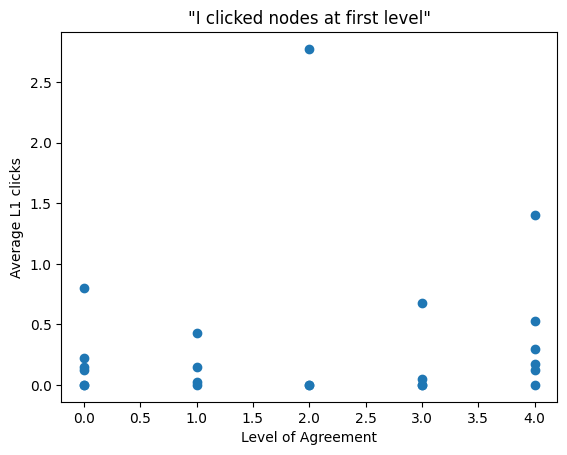

In [259]:
print(strategy_ans_df["Q0"].corr(strategy_ans_df["cL1_mean"]))
plt.scatter(strategy_ans_df["Q0"], strategy_ans_df["cL1_mean"])
plt.title("\"I clicked nodes at first level\"")
plt.xlabel("Level of Agreement")
plt.ylabel("Average L1 clicks")
plt.show()

In [113]:
strategy_ans_df["Q4"].value_counts().sort_index()

Q4
0.0    5
1.0    4
2.0    3
4.0    2
Name: count, dtype: int64

In [156]:
strategy_ans_df.where(strategy_ans_df > 2, 100)

,Q0,Q1,Q2,Q3,Q4,cL1_mean
0,3.0,100.0,100.0,100.0,3.0,100.00
1,3.0,100.0,3.0,100.0,3.0,100.00
2,100.0,100.0,3.0,100.0,100.0,100.00
3,4.0,100.0,4.0,4.0,100.0,100.00
4,3.0,100.0,100.0,3.0,100.0,100.00
5,3.0,100.0,100.0,3.0,100.0,100.00
6,100.0,100.0,100.0,100.0,100.0,100.00
8,4.0,100.0,3.0,100.0,3.0,100.00
9,100.0,3.0,100.0,4.0,4.0,100.00
10,100.0,100.0,100.0,3.0,100.0,100.00


In [165]:
agreement_df == 2

,Q0,Q1,Q2,Q3,Q4,cL1_mean
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,True,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False
5,False,False,False,False,True,False
6,False,False,False,False,False,False
8,False,True,False,False,False,False
9,False,False,False,False,False,False
10,False,False,False,False,False,False


In [172]:
agreement_df = strategy_ans_df.copy()
agreement_df = agreement_df.where(agreement_df >= 2, -1)
agreement_df = agreement_df.where(agreement_df <= 2, 1)
agreement_df = agreement_df.where(agreement_df != 2, 0)
agreement_df["cL1_mean"] = strategy_ans_df["cL1_mean"]

agreement_df

,Q0,Q1,Q2,Q3,Q4,cL1_mean
0,1.0,-1.0,-1.0,-1.0,1.0,0.12
1,1.0,-1.0,1.0,-1.0,1.0,0.36
2,-1.0,-1.0,1.0,-1.0,0.0,0.04
3,1.0,-1.0,1.0,1.0,-1.0,1.96
4,1.0,-1.0,-1.0,1.0,-1.0,0.00
5,1.0,-1.0,-1.0,1.0,0.0,0.60
6,-1.0,-1.0,-1.0,-1.0,-1.0,0.00
8,1.0,0.0,1.0,-1.0,1.0,0.00
9,-1.0,1.0,-1.0,1.0,1.0,0.28
10,-1.0,-1.0,-1.0,1.0,-1.0,0.00


In [176]:
(agreement_df["Q1"] + agreement_df["Q2"]).value_counts()

 0.0    13
-2.0    10
-1.0     4
 1.0     2
Name: count, dtype: int64

In [85]:
correct_answers = {
    "Q0": "$-2 to $2",
    "Q1": "$-16 to $16",
    "Q2": "$-88 to $88"
}

num_correct = {}
questions_correct = {}
bonus = {}

for cond in conditions.keys():
    num_correct[cond] = []
    questions_correct[cond] = {
        "Q0": 0,
        "Q1": 0,
        "Q2": 0
    }
    bonus[cond] = []
    sub_df = complete_data.loc[complete_data.condition == cond]
    for idx, row in sub_df.iterrows():
        part = [p for p in part_stats_dicts if p["workerId"] == row["workerId"]][0]
        part_answers = part['final_quiz_responses']
        part_correct_answers = sum([part_answers[key] == correct_answers[key] for key in correct_answers.keys()])
        num_correct[cond].append(part_correct_answers)
        for q in correct_answers.keys():
            questions_correct[cond][q] += int(part_answers[q] == correct_answers[q])
        part_bonus = full_bonus_eligible.loc[full_bonus_eligible.workerId == row["workerId"]].bonus.values[0]
        bonus[cond].append(part_bonus)



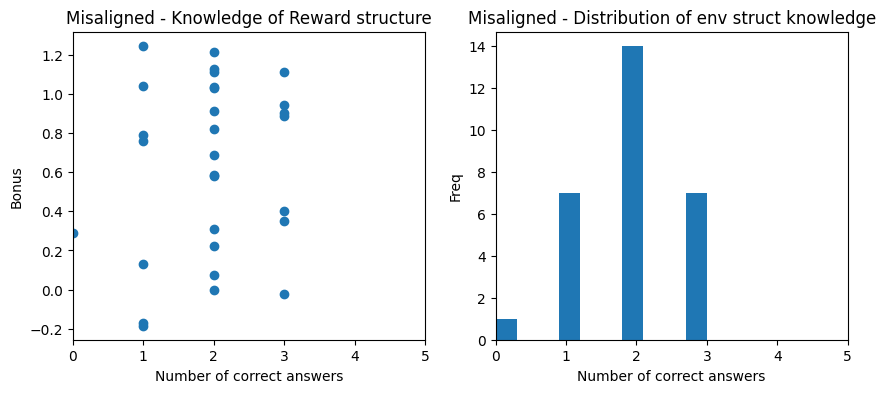

In [86]:


for idx, (cond, condname) in enumerate(conditions.items()):
    plt.figure(figsize=(5 * 2,4 * len(conditions)))
    plt.subplot(1,2,1)
    plt.scatter(num_correct[cond], bonus[cond])
    plt.xlabel("Number of correct answers")
    plt.ylabel("Bonus")
    plt.title(f"{condname} - Knowledge of Reward structure")
    plt.xlim([0,5])
    plt.subplot(1,2,2)
    plt.hist(num_correct[cond])
    plt.xlabel("Number of correct answers")
    plt.ylabel("Freq")
    plt.xlim([0,5])
    plt.title(f"{condname} - Distribution of env struct knowledge")

plt.show()

In [87]:
questions_correct

{0: {'Q0': 20, 'Q1': 13, 'Q2': 23}}